## Setup autoreload, warnings and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

## Set the visibility of cuda devices (in case your system contains more than one)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
# %cd ../..
# %ls

In [4]:
def save_pickle(x, file):
    with open(file, 'wb') as f_file:
        pickle.dump(x, f_file, protocol=4)
        
def load_pickle(file):
    with open(file, 'rb') as f_file:
        result = pickle.load(f_file)
    return result


In [5]:
import torch

print(torch.__version__)

1.10.0+cu111


/ekaterina/env/norppa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Imports

In [6]:
%matplotlib inline
import torch
from config_whaleshark import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import SimpleDataset, DatasetSlice

from tools import apply_pipeline, crop_step, curry, curry_sequential, apply_pipeline_dataset, get_save_step, apply_sequential, compose, compose_sequential
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from pattern_extraction.extract_pattern import smart_resize
from reidentification.identify import encode_single, encode_pipeline, encode_dataset, identify, identify_single, apply_geometric, encode_patches, extract_patches
from reidentification.visualisation import visualise_match
from reidentification.find_matches import find_matches

2023-06-16 17:23:40.054756: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-16 17:23:41.702249: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-06-16 17:23:41.730162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-16 17:23:41.730203: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-16 17:23:41.733747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-06-16 17:23:41.733810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.s

## Create a configuration file.
You can change the default parameters in config.py

In [7]:
cfg = config()

/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
2023-06-16 17:23:49.282468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-16 17:23:49.283367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-06-16 17:23:49.283469: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-06-16 17:2

## Download the dataset

In [8]:
train_path = "/ekaterina/work/data/whaleshark_norppa_tonemapped/train"
test_path = "/ekaterina/work/data/whaleshark_norppa/test"

dataset_train = Path(train_path)
dataset_test = Path(test_path)


print(f'Whaleshark dataset is ready')

Whaleshark dataset is ready


## Create dataset variables

In [9]:
train_dataset = SimpleDataset(dataset_train)
test_dataset = SimpleDataset(dataset_test)

img_data = train_dataset[3]
print(img_data)

(<PIL.Image.Image image mode=RGB size=2400x1909 at 0x7F4126C50210>, {'class_id': 'A-317_right', 'file': '/ekaterina/work/data/whaleshark_norppa_tonemapped/train/A-317_right/000000004298.jpg', 'dataset_dir': PosixPath('/ekaterina/work/data/whaleshark_norppa_tonemapped/train')})


In [9]:
cfg["topk"]=20

In [10]:
def resize_dataset(input, size):
    image, img_label = input
    if image is None:
        return [input]

    result, ratio = smart_resize(image, size, return_ratio=True)
    img_label["resize_ratio"] = ratio
    return [(result, img_label)]

In [11]:
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa

from PIL import Image

import cv2 as cv

cfg["geometric"]["method"] = cv.RANSAC 

def preprocess(input):
    image, img_label = input
    
#     footprint = disk(5)
    
#     result = Image.fromarray(closing(np.array(image.convert("L")), footprint))
#     result = Image.fromarray(skeletonize(np.array(image.convert("L")) > 0.5))

#     result = np.array(image)
#     result[round(result.shape[0]*0.6):, :] = 0
#     result = Image.fromarray(result)
    
    return [(image, img_label)]

In [12]:
def get_topk_matrix(identification_result):
    result = []
    for (db_labels, q_labels) in identification_result:
        q_class = q_labels['class_id']
        q_ln = len(q_labels['labels'])
        result.append([db_label['db_label']['class_id']==q_class for db_label in db_labels]*q_ln)
    return np.asarray(result)


def get_topk_accuracy(identification_result):
    result = []
    for (db_labels, q_labels) in identification_result:
        q_class = q_labels['class_id']
        q_ln = len(q_labels['labels'])
        result.append([db_label['db_label']['class_id']==q_class for db_label in db_labels]*q_ln)
    result = np.asarray(result)
    return [sum((np.sum(result[:, :j+1], axis=1) > 0)) / len(result) for j in range(result.shape[1])]

def print_topk_accuracy(identification_result, label=""):
    topk_acc = get_topk_accuracy(identification_result)
    print(label)
    for (i, acc) in enumerate(topk_acc):
        print(f"Top-{i+1} accuracy: {acc*100}%")
    return identification_result


In [13]:
cfg["hesaff_args"]['patch_scale'] = 1
cfg["patch_extraction"] = "hesaff"

In [15]:
def update_codebooks(input, cfg):
    codebooks, encoded = input
    cfg["codebooks"] = codebooks
    return encoded

encode_pipeline = [
    curry_sequential(resize_dataset, 256),
#     apply_sequential(preprocess),
    curry(encode_dataset, cfg=cfg)
#     curry(encode_dataset, cfg, compute_codebooks=True),
#     curry(update_codebooks, cfg)
]
# test_dataset_mini = DatasetSlice(test_dataset, range(5))
# train_dataset_mini = DatasetSlice(train_dataset, range(20))

# wrong_matches = load_pickle("wrong_match_inds.pickle")
# train_dataset_mini = DatasetSlice([train_dataset[i] for i in wrong_matches], range(100))

encoded_train_dataset = apply_pipeline_dataset(train_dataset, encode_pipeline)

KeyboardInterrupt: 

In [ ]:
encode_pipeline = [
    curry_sequential(resize_dataset, 256),
    get_save_step("/ekaterina/work/data/whaleshark_norppa_tonemapped_resized/train"),
#     curry(encode_dataset, cfg, compute_codebooks=True),
#     curry(update_codebooks, cfg)
]


# wrong_matches = load_pickle("wrong_match_inds.pickle")
# train_dataset_mini = DatasetSlice([train_dataset[i] for i in wrong_matches], range(100))

wrong_dataset = apply_pipeline_dataset(train_dataset, encode_pipeline, verbose=True)

In [14]:
import kornia as K
import kornia.feature as KF
from kornia_moons.feature import *

def deaffinize_laf(laf):
    xy = KF.laf.get_laf_center(laf)
    sc = KF.laf.get_laf_scale(laf)
    ori = KF.laf.get_laf_orientation(laf)
    return KF.laf.laf_from_center_scale_ori(xy, sc, ori)

def get_lafs_and_descriptors(img, harrisz_kpts,
                             kornia_descriptor,
                             ori,
                             aff,
                             aff_string = 'def',
                             mrSize=1.0,
                             num_feats = 2048, device=torch.device('cuda')):
    # We will not train anything, so let's save time and memory by no_grad()
    with torch.no_grad():
        timg = K.image_to_tensor(img, False).float()/255.
        timg = timg.to(device)
#         timg = K.color.rgb_to_grayscale(timg)
        # timg = K.color.rgb_to_grayscale(K.image_to_tensor(img, False))/255.
        # timg = timg.to(device)
        hz_pt = torch.from_numpy(harrisz_kpts).float()
        lafs = KF.laf.ellipse_to_laf(hz_pt[None])
        lafs[0,:,0,0] = hz_pt[:,2] * mrSize
        lafs[0,:,0,1] = hz_pt[:,3] * mrSize
        lafs[0,:,1,0] = hz_pt[:,3] * 0
        lafs[0,:,1,1] = hz_pt[:,4] * mrSize
        lafs = lafs.to(timg.device)
        # border image changed from 5 to 10 !!!
        good_lafs_mask = KF.laf.laf_is_inside_image(lafs, timg, 10)
        # all taken!!!
        # good_lafs_mask[:] = True 
        good_lafs = lafs[good_lafs_mask][None]
        if aff_string == 'def':
            out_lafs = good_lafs
        elif aff_string == 'no':
            out_lafs = deaffinize_laf(good_lafs)
        elif aff_string == 'affnet':
            out_lafs = deaffinize_laf(good_lafs)
            out_lafs = aff(out_lafs,timg)
        elif aff_string == 'orinet_affnet':
            out_lafs = deaffinize_laf(good_lafs)
            out_lafs = ori(aff(out_lafs,timg),timg)
        else:
            raise ValueError('Unknown affine str')
        out_lafs = out_lafs[:,:num_feats]
        # We will estimate affine shape of the feature and re-orient the keypoints with the OriNet
        patches = KF.extract_patches_from_pyramid(timg,out_lafs, 32)
        B, N, CH, H, W = patches.size()
        # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
        # So we need to reshape a bit :) 
        descs = kornia_descriptor(patches.view(B * N, CH, H, W)).view(B * N, -1)
    return out_lafs, descs.detach().cpu().numpy()#, good_lafs_mask[0].detach().cpu().numpy()

In [16]:

from extract_patches.laf import LAFs2ell
from extract_patches.core import extract_patches as keypoints_to_patches
from torchvision import transforms
from tqdm import tqdm

import scipy.io
import os

# import h5py

# f = h5py.File('/ekaterina/work/src/NORPPA/repository/NORPPA/temp/files/result_pattern_tonemapped_wrong.mat','r')
# data = f.get('data/result')
# data = np.array(data)

# train_path = "/ekaterina/work/data/whaleshark_wrong_pattern_mini"
train_path = "/ekaterina/work/data/whaleshark_norppa_tonemapped_resized/train"
dataset_train = Path(train_path)
train_dataset = DatasetSlice(SimpleDataset(dataset_train), range(20))

mat = scipy.io.loadmat('/ekaterina/work/src/NORPPA/repository/NORPPA/temp/files/result_tonemapped_train.mat')
mat["result"][0, 2]

def get_class_and_name(full_path):
    head, file = os.path.split(full_path)
    _, class_name = os.path.split(head)
    return os.path.join(class_name, file)

def cell_to_dict(mat):
    res = {}
    for i in range(mat.shape[0]):
        res[os.path.join(mat[i, 0][0], mat[i, 1][0])] = mat[i, 2]
    return res

matdict = cell_to_dict(mat['result'])

def patchify_load(dataset, file, config):
    mat = scipy.io.loadmat(file)
    matdict = cell_to_dict(mat['result'])
    
    net = config["net"]
    result = []
    labels = []
    inds = []
    all_ells = []
    ind = 0
    num_files = len(dataset)
    dataset_transforms = transforms.Grayscale(num_output_channels=1)
    
    if config['use_cuda']:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    PS = 32
    descriptor = KF.HardNet(True)
#     descriptor = KF.HardNet8(True)        
    
    descriptor = descriptor.to(device)
    # print (device)
    descriptor.eval()
    aff_est = KF.LAFAffNetShapeEstimator(True).to(device)
    orienter = KF.LAFOrienter(32, angle_detector=KF.OriNet(True)).to(device)
    orienter.eval()
    aff_est.eval()
    NUM_KP = 500
    
    for i, (image, img_label) in enumerate(tqdm(dataset)):
        if image is None:
            all_ells.append(None)
            labels.append(img_label)
            continue
        image = dataset_transforms(image)
        num_files-=1
        if sum(image.getextrema()) == 0:
            all_ells.append(None)
            labels.append(img_label)
            continue
#         patches, ells = patch_extraction(image, config)
        key = get_class_and_name(img_label['file'])
        if key not in matdict:
            continue

        hz_kpts = matdict[key]
        
        lafs, descs = get_lafs_and_descriptors(np.array(image), hz_kpts,
                     descriptor,
                     orienter,
                     aff_est,
                     aff_string = "affnet", # "orinet_affnet", # 
                     mrSize=1,
                     num_feats = NUM_KP, device=device)
#         print(descs.shape)
        patch_features = descs
        ells = LAFs2ell(np.array(lafs[0].cpu()))
        
#         ells = LAFs2ell(LAFs)
#         patches = keypoints_to_patches(ells, np.array(image), 32, 1, 'ellipse')
        
#         if patches is None or len(patches) == 0:
#             continue
#         patch_features = torch.from_numpy(patches/255).float().unsqueeze(1)
#         if config["use_cuda"]:
#             patch_features = patch_features.cuda()
#         patch_features = apply_batch_net(patch_features, net, batch_size=config["batch_size"])
        all_ells.append(ells)
        inds.extend([i] * patch_features.shape[0])
        labels.append(img_label)
        result.append(patch_features)
#         del patches
#         gc.collect()
    labels = np.array(labels)
    return np.vstack(result), np.array(inds), labels, all_ells

def extract_patches_load(dataset, file, config):
    return (dataset, patchify_load(dataset, file, config))

keypoints_path = '/ekaterina/work/src/NORPPA/repository/NORPPA/temp/files/result_tonemapped_train.mat'

pipeline = [
    curry(extract_patches_load, file=keypoints_path, config=cfg),
    curry(encode_patches, cfg=cfg)
]

encoded_train_dataset = apply_pipeline_dataset(train_dataset, pipeline, verbose=True)


/ekaterina/env/norppa/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `LAFAffNetShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 12.17it/s]
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/identify.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_ells = np.array(all_ells)


Completed 1/2 steps
/ekaterina/work/src/NORPPA/repository/NORPPA/codebooks/whaleshark_tonemapped_harrisz.pickle
Calculating PCA
Getting encoding parameters...
Encoding...
Completed 2/2 steps


In [ ]:
# save_pickle(codebooks, "/ekaterina/work/src/NORPPA/repository/NORPPA/codebooks/whaleshark_tonemapped_harrisz.pickle")

In [ ]:
mat["result"][0, 2][0, ]

In [ ]:
img = train_dataset_mini[0][0]
img = np.array(smart_resize(img, 256, return_ratio=False))

In [ ]:
import cv2

sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=9, contrastThreshold=0.04, edgeThreshold=10, sigma=8)

keypoints = sift.detect(img)

img2=cv2.drawKeypoints(img,keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

Image.fromarray(img2)

In [ ]:
sift.nfeatures

In [ ]:
# with open("tonemapped_pattern_whaleshark_scale2.pickle", 'rb') as f_file:
#     encoded_train_dataset = pickle.load(f_file)

In [26]:
# test_pipeline = [
#                  curry(identify, encoded_train_dataset, cfg["topk"]),
#                  curry_sequential(find_matches, cfg),
#                  curry_sequential(apply_geometric, cfg["geometric"]),
#                  curry_sequential(visualise_match, cfg["topk"])
#                 ]

# encoded_test_dataset = apply_pipeline_dataset(test_dataset_mini, encode_pipeline + test_pipeline)

test_pipeline1 = [
                 curry(identify, encoded_train_dataset, cfg["topk"], leave_one_out=True),
                 curry(print_topk_accuracy, label="Before geometric verification:"),
                ]
test_pipeline2 = [
                 curry_sequential(find_matches, cfg),
                 curry_sequential(apply_geometric, cfg["geometric"]),
                 curry(print_topk_accuracy, label="After geometric verification:"),
#                  curry_sequential(visualise_match, cfg["topk"])
                ]

matches1 = apply_pipeline_dataset(encoded_train_dataset, test_pipeline1)
None

20


100%|████████████████████████████████████████| 20/20 [00:00<00:00, 21071.61it/s]

Before geometric verification:
Top-1 accuracy: 95.0%
Top-2 accuracy: 100.0%
Top-3 accuracy: 100.0%
Top-4 accuracy: 100.0%
Top-5 accuracy: 100.0%
Top-6 accuracy: 100.0%
Top-7 accuracy: 100.0%
Top-8 accuracy: 100.0%
Top-9 accuracy: 100.0%
Top-10 accuracy: 100.0%
Top-11 accuracy: 100.0%
Top-12 accuracy: 100.0%
Top-13 accuracy: 100.0%
Top-14 accuracy: 100.0%
Top-15 accuracy: 100.0%
Top-16 accuracy: 100.0%
Top-17 accuracy: 100.0%
Top-18 accuracy: 100.0%
Top-19 accuracy: 100.0%
Top-20 accuracy: 100.0%


In [35]:

matches, query_labels = matches2[0]
query_images = query_labels["labels"]

match = matches[0]
# match
# query_images

In [36]:
matches2 = apply_pipeline_dataset(matches1, test_pipeline2)

# with open("tonemapped_pattern_whaleshark_scale2_matches.pickle", 'wb') as f_file:
#     pickle.dump(codebooks, f_file, protocol=4)
# None

# Scale 2
# Top-1 accuracy: 31.0%
# Top-2 accuracy: 49.0%
# Top-3 accuracy: 55.00000000000001%
# Top-4 accuracy: 59.0%
# Top-5 accuracy: 66.0%

# Scale 2 (no resize)
# Top-1 accuracy: 26.0%
# Top-2 accuracy: 43.0%
# Top-3 accuracy: 55.00000000000001%
# Top-4 accuracy: 61.0%
# Top-5 accuracy: 68.0%

# Scale 1
# Top-1 accuracy: 22.0%
# Top-2 accuracy: 26.0%
# Top-3 accuracy: 42.0%
# Top-4 accuracy: 49.0%
# Top-5 accuracy: 52.0%

# Scale 3
# Top-1 accuracy: 26.0%
# Top-2 accuracy: 41.0%
# Top-3 accuracy: 53.0%
# Top-4 accuracy: 62.0%
# Top-5 accuracy: 70.0%


# Scale 1
# Before geometric verification:
# Top-1 accuracy: 27.0%
# Top-2 accuracy: 41.0%
# Top-3 accuracy: 48.0%
# Top-4 accuracy: 55.00000000000001%
# Top-5 accuracy: 56.00000000000001%

# After geometric verification:
# Top-1 accuracy: 42.0%
# Top-2 accuracy: 51.0%
# Top-3 accuracy: 61.0%
# Top-4 accuracy: 66.0%
# Top-5 accuracy: 71.0%

# Scale 1 tonemapped + tonemapped codebooks

# Before GV
# Top-1 accuracy: 41.0%
# Top-2 accuracy: 55.00000000000001%
# Top-3 accuracy: 57.99999999999999%
# Top-4 accuracy: 63.0%
# Top-5 accuracy: 71.0%

# After GV
# Top-1 accuracy: 47.0%
# Top-2 accuracy: 59.0%
# Top-3 accuracy: 64.0%
# Top-4 accuracy: 69.0%
# Top-5 accuracy: 73.0%

# Scale 2 tonemapped + tonemapped codebooks

# Before GV


# After GV


After geometric verification:
Top-1 accuracy: 90.0%
Top-2 accuracy: 100.0%
Top-3 accuracy: 100.0%
Top-4 accuracy: 100.0%
Top-5 accuracy: 100.0%
Top-6 accuracy: 100.0%
Top-7 accuracy: 100.0%
Top-8 accuracy: 100.0%
Top-9 accuracy: 100.0%
Top-10 accuracy: 100.0%
Top-11 accuracy: 100.0%
Top-12 accuracy: 100.0%
Top-13 accuracy: 100.0%
Top-14 accuracy: 100.0%
Top-15 accuracy: 100.0%
Top-16 accuracy: 100.0%
Top-17 accuracy: 100.0%
Top-18 accuracy: 100.0%
Top-19 accuracy: 100.0%
Top-20 accuracy: 100.0%


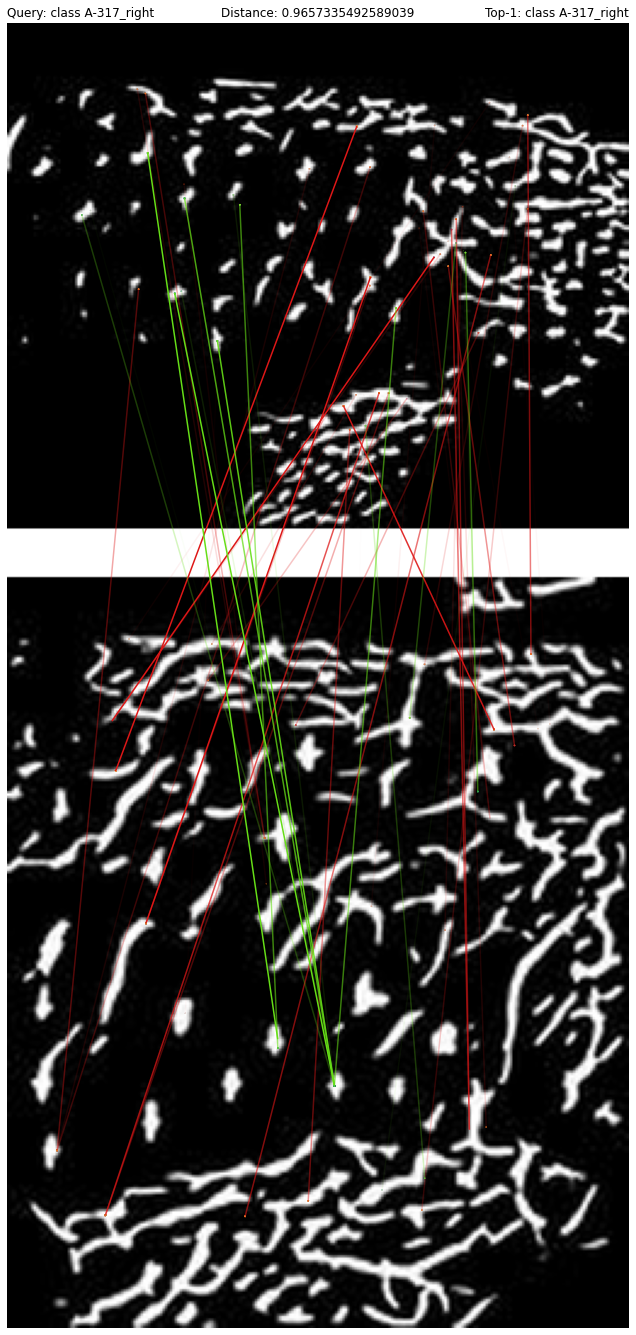

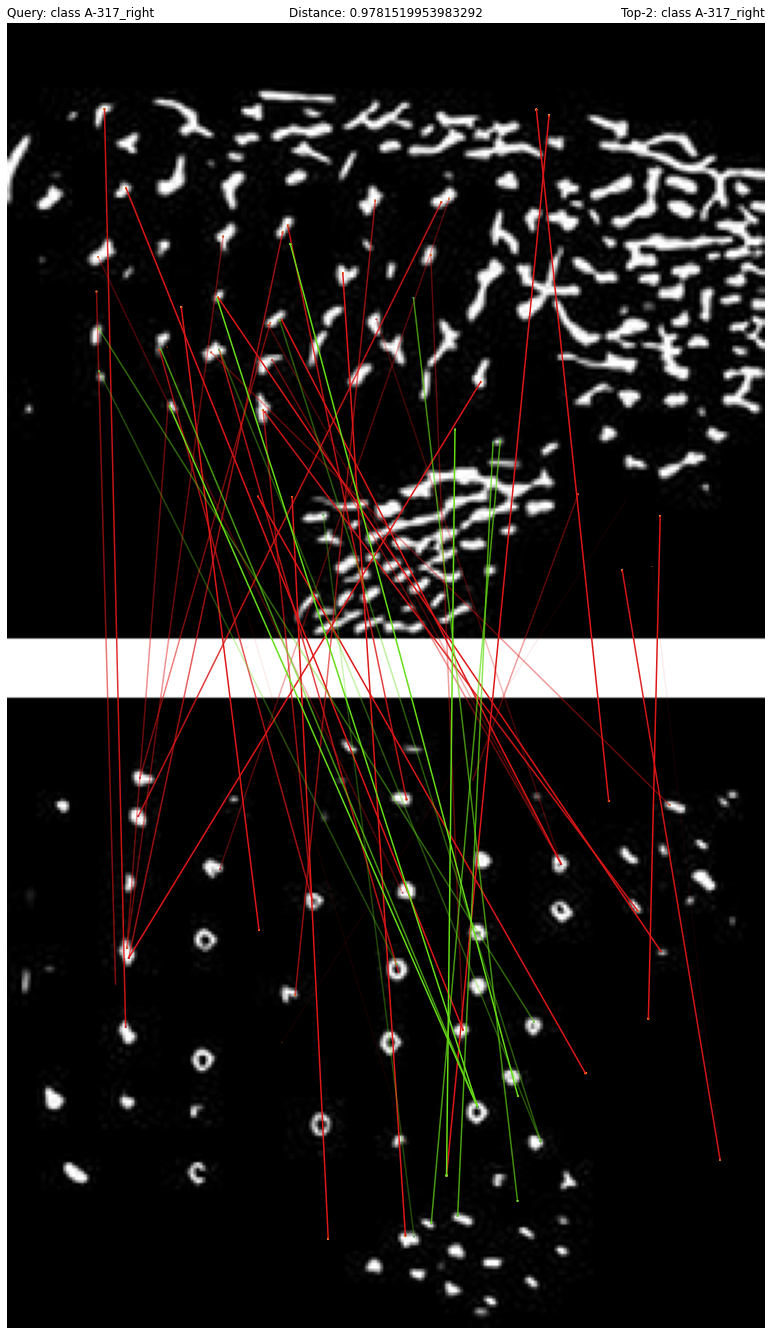

KeyboardInterrupt: 

In [37]:
curry_sequential(visualise_match, 5)(matches2[:5])

In [ ]:
matches, query_label = matches2[0]

def get_label(lb):
    return lb['labels'][0]['class_id']

def get_db_label(lb):
    return get_label(lb['db_label'])

get_db_label(matches[0])

get_label(query_label)

wrong_matches = [i for (i, (matches, query_label)) in enumerate(matches2) if not any([get_db_label(match)==get_label(query_label) for match in matches[:5]])]



[autoreload of torch failed: Traceback (most recent call last):
  File "/ekaterina/env/norppa/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/ekaterina/env/norppa/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/ekaterina/env/norppa/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/ekaterina/env/norppa/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/ekaterina/env/norppa/lib/python3.7/site-packages/torch/__init__.py", line 22, in <module>
    from ._utils import _import_dotted_name, classproperty
ImportError: cannot import name

In [ ]:
# wrong_matches[0][1]

# hard_labels = set([get_label(wrong_match[1]) for wrong_match in wrong_matches])

# hard_labels

In [ ]:
# len(wrong_matches)

# hard_dataset = [train_dataset[i] for i in wrong_matches]

In [ ]:
# save_pickle(wrong_matches, "wrong_match_inds.pickle")

In [ ]:
train_dataset[0][1]

In [ ]:
len(train_dataset)

In [ ]:
len([(img, label) for (img, label) in train_dataset if label['class_id'] in hard_labels])